# EduVerse USA Chatbot — Intent Classification

## NLP Pipeline Module 2

This notebook classifies user queries into intent categories.

### Intent Categories
- **admissions**: University application queries
- **sop**: Statement of Purpose guidance
- **scholarships**: Funding and financial aid
- **test_prep**: GRE, TOEFL, IELTS preparation

### Approach
TF-IDF features + Logistic Regression with confidence scoring.

---
## 1. Setup

In [4]:
!pip install scikit-learn pandas matplotlib seaborn -q

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

print("Setup complete")

Setup complete


---
## 2. Training Dataset

In [7]:
data = {
    'text': [
        # Admissions (12 samples)
        "What documents are required for MS admissions?",
        "Application deadline for fall intake at Stanford",
        "How many letters of recommendation do I need?",
        "What GPA is required for top universities?",
        "Requirements for PhD admission in computer science",
        "How to apply for graduate school in America",
        "What is the application process for US universities?",
        "Transcript requirements for international students",
        "When should I start my application for fall 2026?",
        "Do I need work experience for MBA admission?",
        "University application checklist for MS programs",
        "Prerequisites for data science masters degree",
        
        # SOP (12 samples)
        "How do I write a strong statement of purpose?",
        "Can you review my SOP draft?",
        "What should I include in my personal statement?",
        "SOP tips for computer science programs",
        "How long should my statement of purpose be?",
        "Structure of a good SOP for MS applications",
        "Common mistakes to avoid in SOP writing",
        "How to show motivation in my personal statement",
        "Should I mention my research experience in SOP?",
        "How to write about career goals in SOP",
        "Essay writing tips for graduate admissions",
        "Personal statement examples for PhD applications",
        
        # Scholarships (12 samples)
        "Are there scholarships for international students?",
        "Fulbright scholarship application process",
        "How to get funding for MS in USA?",
        "Teaching assistantship opportunities",
        "Research assistantship for PhD students",
        "Merit-based scholarships at MIT",
        "Financial aid options for graduate students",
        "How to apply for university scholarships?",
        "Tuition fee waiver for international students",
        "External fellowship opportunities in the US",
        "Assistantship vs scholarship difference",
        "Need-based financial aid for masters programs",
        
        # Test Prep (12 samples)
        "How to prepare for GRE in 2 months?",
        "TOEFL vs IELTS - which is easier?",
        "What GRE score do I need for top programs?",
        "Best resources for TOEFL preparation",
        "IELTS speaking test tips",
        "GRE verbal section strategies",
        "How to improve my TOEFL writing score?",
        "GRE quantitative practice questions",
        "Minimum IELTS score for US universities",
        "GRE study plan for working professionals",
        "TOEFL reading section time management",
        "AWA essay tips for GRE"
    ],
    'intent': (
        ['admissions'] * 12 + 
        ['sop'] * 12 + 
        ['scholarships'] * 12 + 
        ['test_prep'] * 12
    )
}

df = pd.DataFrame(data)
print(f"Dataset: {len(df)} samples")
print(f"\nIntent distribution:")
print(df['intent'].value_counts())

Dataset: 48 samples

Intent distribution:
intent
admissions      12
sop             12
scholarships    12
test_prep       12
Name: count, dtype: int64


---
## 3. Intent Distribution

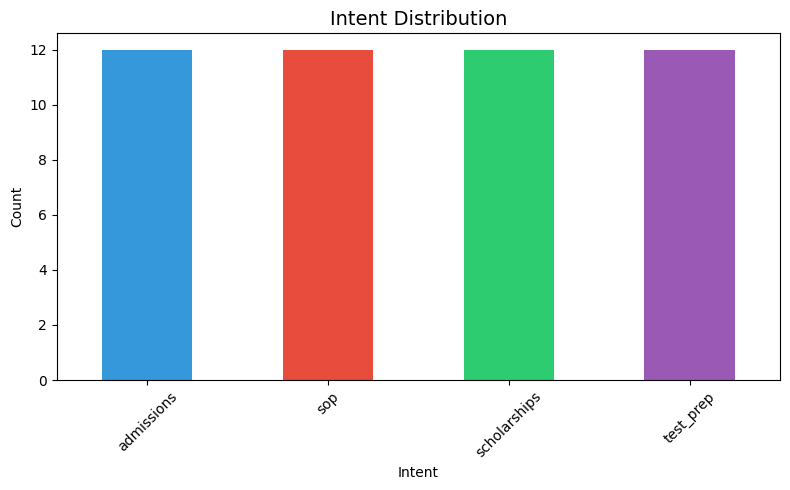

In [9]:
plt.figure(figsize=(8, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
df['intent'].value_counts().plot(kind='bar', color=colors)
plt.title('Intent Distribution', fontsize=14)
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
## 4. TF-IDF Feature Extraction

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['intent'], 
    test_size=0.25, 
    random_state=42,
    stratify=df['intent']
)

# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=1000,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Training samples: {X_train_tfidf.shape[0]}")
print(f"Test samples: {X_test_tfidf.shape[0]}")
print(f"Features: {X_train_tfidf.shape[1]}")

Training samples: 36
Test samples: 12
Features: 206


---
## 5. Model Comparison

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=3)
    
    # Train and evaluate
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    test_acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'CV Mean': f"{cv_scores.mean():.3f}",
        'CV Std': f"{cv_scores.std():.3f}",
        'Test Acc': f"{test_acc:.3f}"
    })
    print(f"{name}: CV={cv_scores.mean():.3f}, Test={test_acc:.3f}")

pd.DataFrame(results)

Logistic Regression: CV=0.861, Test=0.667
Naive Bayes: CV=0.750, Test=0.583
Linear SVM: CV=0.833, Test=0.667
Random Forest: CV=0.778, Test=0.750


,Model,CV Mean,CV Std,Test Acc
0,Logistic Regression,0.861,0.104,0.667
1,Naive Bayes,0.750,0.000,0.583
2,Linear SVM,0.833,0.068,0.667
3,Random Forest,0.778,0.157,0.750


---
## 6. Final Model Evaluation

In [15]:
# Use Logistic Regression as final model
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

  admissions       0.33      0.33      0.33         3
scholarships       0.33      0.33      0.33         3
         sop       1.00      1.00      1.00         3
   test_prep       1.00      1.00      1.00         3

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.67        12
weighted avg       0.67      0.67      0.67        12



---
## 7. Confusion Matrix

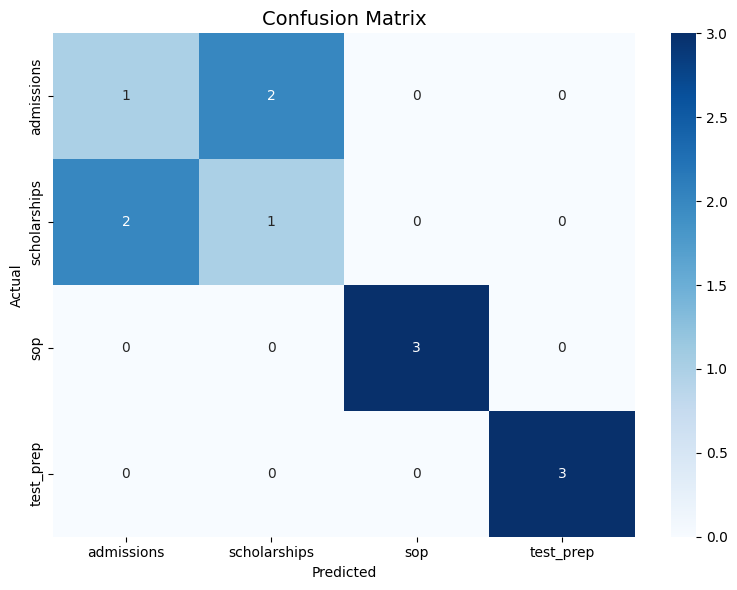

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

---
## 8. Confidence Scoring

In [19]:
def predict_with_confidence(text):
    """Predict intent with confidence score."""
    vec = tfidf.transform([text])
    probs = model.predict_proba(vec)[0]
    pred = model.predict(vec)[0]
    conf = max(probs)
    return pred, conf, dict(zip(model.classes_, probs))

# Test examples
test_queries = [
    "How to prepare for GRE verbal section?",
    "Scholarship opportunities at Harvard",
    "Tips for writing a compelling SOP",
    "What are the admission requirements for MIT?"
]

print("Intent Predictions:")
print("=" * 60)
for query in test_queries:
    intent, conf, probs = predict_with_confidence(query)
    print(f"\nQuery: {query}")
    print(f"Intent: {intent} (confidence: {conf:.1%})")

Intent Predictions:

Query: How to prepare for GRE verbal section?
Intent: test_prep (confidence: 49.2%)

Query: Scholarship opportunities at Harvard
Intent: scholarships (confidence: 42.4%)

Query: Tips for writing a compelling SOP
Intent: sop (confidence: 44.7%)

Query: What are the admission requirements for MIT?
Intent: admissions (confidence: 33.2%)


---
## 9. Feature Importance

In [21]:
feature_names = tfidf.get_feature_names_out()

for i, intent in enumerate(model.classes_):
    coef = model.coef_[i]
    top_idx = np.argsort(coef)[-5:][::-1]
    top_features = [feature_names[j] for j in top_idx]
    print(f"\n{intent}: {', '.join(top_features)}")


admissions: need, application, ms, fall, admission

scholarships: students, assistantship, opportunities, scholarships, scholarship

sop: statement, sop, personal, personal statement, purpose

test_prep: gre, ielts, toefl, section, months


---
## 10. Summary

### Model Performance
- **Logistic Regression** provides good accuracy with probability estimates
- **TF-IDF bigrams** capture discriminative phrases

### Key Takeaways
1. Confidence scores help identify ambiguous queries
2. Feature analysis reveals key terms for each intent
3. Balanced dataset ensures fair classification across intents